# Distance Estimation and Angle Recovery

TODO: put equateions

## Content

1. [Data Preparation](#1.-Data-Preparation)
2. [Distance Estimation](#2.-Distance-Estimation)
3. [Angle Recovery](#3.-Angle-Recovery)
4. [Angle Alignment](#4.-Angle-Alignment)

Data used:
- Protein: 5j0n (symmetric protein)
- Projections: 5K
- Coverage: Half-sphere

![](figures/5j0n.pdb1-500.jpg)

Data download:
- [data/5j0n/5j0n_siamese_idx.npz](https://mega.nz/file/uoNTFKba#jb-pX004xX41iqWzc-1d3tdS6baxRLvaK5VZmw1riCc)
- [training/20200531_224202.h5](https://mega.nz/file/f8VBgQpA#UFZgWbrdq856Jt5VM7vDYx86vgCRxIxtfumtfaeS6xI)
- [data/5j0n/5j0n_ProjectionsAngles_ProjNber5000_AngCoverage2.0,0.4,2.0_AngShift0.0,0.0,0.0.h5](https://mega.nz/file/nxkBWBrL#2AtjDfKd8YpX2ca2ywJHEQuBdqW4RYPyrF-SnfNNRxA)

In [32]:
from numba import cuda
cuda.select_device(0)
cuda.close()

In [2]:
import os
import h5py
import numpy as np
import time
import pandas as pd

import sys
sys.path.append("../..") 
from cryoem.plots import plot_angles_count, plot_images
from IPython.display import Image
import matplotlib.pyplot as plt

import tensorflow as tf
from cryoem.conversions import d_q, euler2quaternion
import ipyvolume as ipv
from collections import Counter
import itertools
import seaborn as sns; sns.set(style="white", color_codes=True)
import io

In [3]:
tf.__version__

'2.1.0'

In [4]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2671944619410051161
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 664658672221421147
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 2735757509785088473
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11322146816
locality {
  bus_id: 2
  numa_node: 1
  links {
  }
}
incarnation: 15887694305062308176
physical_device_desc: "device: 0, name: Tesla K40c, pci bus id: 0000:da:00.0, compute capability: 3.5"
]


# 1. Data Preparation

In [5]:
PROTEIN="5j0n"
ROOT_DIR = "../.."
NUM_PROJECTIONS = 5000

In [6]:
# location of *.h5 files
data_dir = "data/5j0n/"

# half coverage (AngCoverage=0.5)
projections_filename = f"{PROTEIN}_ProjectionsAngles_ProjNber5000_AngCoverage2.0,0.4,2.0_AngShift0.0,0.0,0.0.h5"

# load structures
data = h5py.File(os.path.join(data_dir, projections_filename), 'r')

print(f"{data['Projections'].shape[0]} projections of images with dimension {data['Projections'].shape[1:]} pixels")
print(f"{data['Angles'].shape[0]} sets of {data['Angles'].shape[1]} ground truth angles of corresponding projection images")

5000 projections of images with dimension (116, 116) pixels
5000 sets of 3 ground truth angles of corresponding projection images


In [7]:
projections = data['Projections']
projections.shape

(5000, 116, 116)

In [8]:
angles_true = np.array(data['Angles'])
angles_true.shape

(5000, 3)

In [9]:
# plot_angles_count(angles_true)

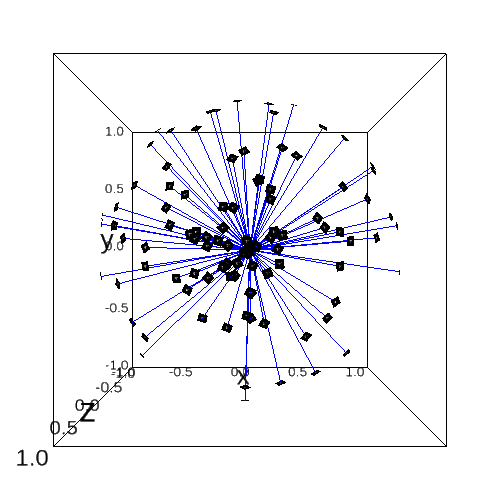

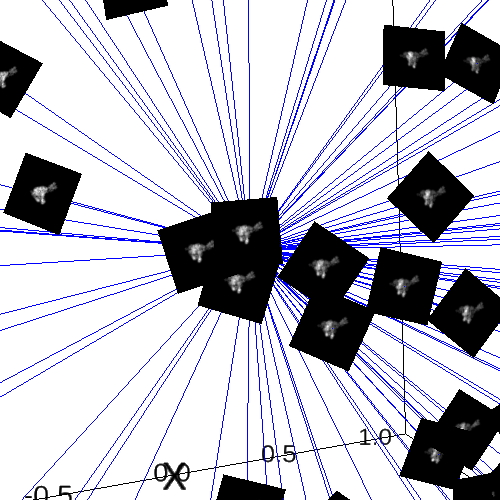

In [10]:
plot_images(angles_true, projections, range(100), img_size_scale=0.05)

In [24]:
ipv.screenshot()

Output()

#### X - projections, y - angles

In [11]:
X, y = np.array(data['Projections'], dtype=np.float32), np.array(data['Angles'], dtype=np.float32)

#### Global standardization of projections

In [12]:
from cryoem.distance_estimation import global_standardization

In [13]:
X = global_standardization(X)

Image shape: (116, 116)
Data Type: float32
***
Mean: 0.262 | Std: 1.046
Min:  0.000 | Max: 15.458
Mean: 0.000 | Std: 1.000
Min:  -0.250 | Max: 14.526


#### Read training/validation/test sets

In [14]:
data = np.load("data/5j0n/5j0n_siamese_idx.npz")
train_idx, val_idx, test_idx = data["arr_0"], data["arr_1"], data["arr_2"]

In [17]:
train_idx.shape, val_idx.shape, test_idx.shape

((2512,), (838,), (1650,))

In [16]:
# print(f"TRAIN: {1-test_size:.2f} x {1-val_size:.2f} = {(1-test_size)*(1-val_size):.2f} => {str(int((1-test_size)*(1-val_size)*5000)).rjust(5)} imgs => max pairs: {str(int(np.power((1-test_size)*(1-val_size)*5000, 2))).rjust(10)}")
# print(f"TEST : {str(test_size).rjust(18)} => {str(int(test_size*5000)).rjust(5)} imgs => max pairs: {str(int(np.power(test_size*5000, 2))).rjust(10)}")
# print(f"VAL  : {1-test_size:.2f} x {val_size:.2f} = {(1-test_size)*val_size:.2f} => {str(int((1-test_size)*val_size*5000)).rjust(5)} imgs => max pairs: {str(int(np.power((1-test_size)*val_size*5000, 2))).rjust(10)}")

In [18]:
# duplicate one channel to make 3 image channels
X = np.stack((X,)*3, axis=-1)

In [19]:
X.shape

(5000, 116, 116, 3)

# 2. Distance Estimation

#### Read model checkpoint

In [20]:
model_filename = "training/20200531_224202.h5"

In [21]:
# Recreate the exact same model, including its weights and the optimizer
model = tf.keras.models.load_model(model_filename)

# Show the model architecture
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 116, 116, 3) 0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 116, 116, 3) 0                                            
__________________________________________________________________________________________________
lambda_11 (Lambda)              (None, 116, 116, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
lambda_12 (Lambda)              (None, 116, 116, 3)  0           input_8[0][0]                    
____________________________________________________________________________________________

---

## dP/dQ plot

In [23]:
from cryoem.conversions import d_q, euler2quaternion
from cryoem.plots import plot_dP_dQ

In [24]:
def d_p(p1, p2):
    p1 = tf.cast(p1, dtype=tf.float32)
    p2 = tf.cast(p2, dtype=tf.float32)
    return model.predict([p1, p2], batch_size=256)

In [25]:
idx1 = list(np.random.choice(test_idx, size=1000))
idx2 = list(np.random.choice(test_idx, size=1000))

q1_true = euler2quaternion([angles_true[i] for i in idx1])
q2_true = euler2quaternion([angles_true[i] for i in idx2])

p1 = [X[i] for i in idx1]
p2 = [X[i] for i in idx2]

dP_values = d_p(p1, p2).T[0]
dQ_values = d_q(q1_true, q2_true).numpy()

<Figure size 432x288 with 0 Axes>

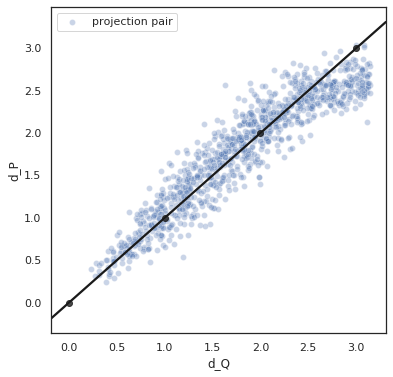

<Figure size 432x288 with 0 Axes>

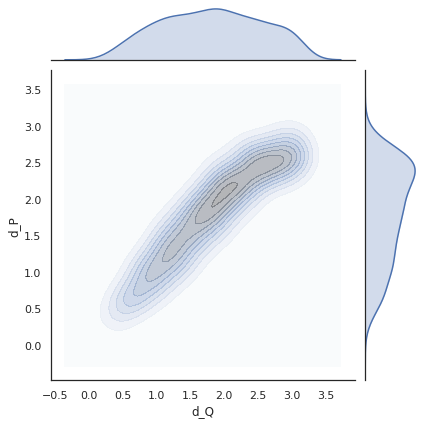

Variance = 0.2598980040333693
Min. angle recovery loss possible = 0.06747942552802871


In [26]:
plot_dP_dQ(dP_values, dQ_values)

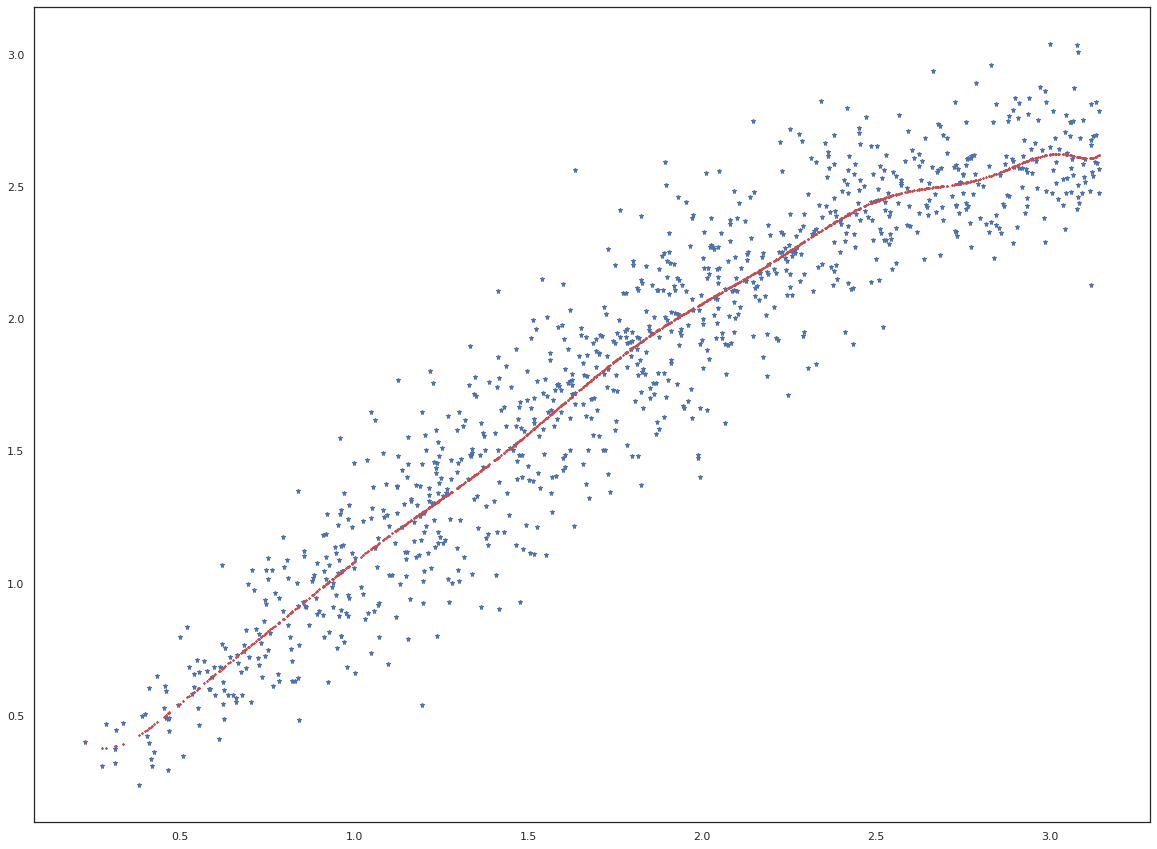

In [29]:
"""Notebook link: https://github.com/JelenaBanjac/protein-reconstruction/blob/38335b2aa0468a5a8739e5c289e0a1251e7fb1ab/notebooks/bgal_optimization_predicted_angle_and_true_projection_(random_and_polyfit)-CONSTRAINED-TODO.ipynb"""
coeffs4dP = np.polyfit(dQ_values, dP_values, deg=14)
convert2dP = np.poly1d(coeffs4dP)

plt.figure(figsize=(20,15))
plt.plot(dQ_values, dP_values, marker="*", markersize=5, lw=0)
plt.plot(dQ_values, convert2dP(dQ_values), marker="*", markersize=2, lw=0, c="r");

# 3. Angle Recovery

Perfect distances. Learning rate 0.01

In [30]:
# QUATERNION VARIABLE
import time
import numpy as np
from IPython import display as IPyDisplay
from tensorflow.keras.optimizers import Adam
import seaborn as sns; sns.set(style="white", color_codes=True)
from tensorflow_graphics.geometry.transformation import quaternion
from cryoem.conversions import euler2quaternion, d_q, quaternion2euler
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R


def angles_transpose(angles):
    angles = angles.copy()
    cols = [2, 1, 0]
    idx = np.empty_like(cols)
    idx[cols] = np.arange(len(cols))
    angles[:] = -angles[:, idx]
    return angles


def train_angle_recovery(steps, 
                         batch_size, 
                         in_data, 
                         distance_fn, 
                         file_name,
                         dt_type, 
                         space,
                         q_predicted=None,
                         angles_true=None,
                         learning_rate=0.01, 
                         optimization=False): 
    """
    space: dQspace, dPspace
        In which space the subtraction will be performed
    dt_type: dP, dQ
        In what ispace is distance_target? 
    """
    
    time_start = time.time()
    collect_data = []
    optimizer = Adam(learning_rate=learning_rate)
    
    low_ang = [0.0*np.pi, 0.0*np.pi, 0.0*np.pi]
    high_ang = [2.0*np.pi, 0.4*np.pi, 2.0*np.pi]            
    euler = np.random.uniform(low=[low_ang[0], low_ang[1], low_ang[2]], 
                          high=[high_ang[0], high_ang[1], high_ang[2]],
                          size=(len(in_data), 3))
    if q_predicted:
        # continue where left off
        q_predicted = [tf.Variable(q) for q in q_predicted]
    else:
        # optimize from scratch
        q_predicted = [tf.Variable(q) for q in euler2quaternion(euler)]

    if in_data.shape[1] == 3:
        in_data = euler2quaternion(in_data)
    
    losses = np.empty(steps)
    report = f"Shape of projections: {in_data.shape}"
    found_minimizer = False
    
    print(time.time()-time_start)
    
    for step, idx1, idx2 in sample_iter(steps, range(len(in_data)), batch_size, style="random"):
        #q_predicted = quaternion.normalize(q_predicted)
        q1 = [q_predicted[i] for i in idx1]
        q2 = [q_predicted[i] for i in idx2]

        # Compute distances
        in1 = [in_data[i] for i in idx1]
        in2 = [in_data[i] for i in idx2]
        
        distance_target = distance_fn(in1, in2)

        # Optimize by gradient descent.
        if optimization:
            losses[step-1], gradients = gradient(q1, q2, distance_target, dt_type, space)
            optimizer.apply_gradients(zip(gradients, q1 + q2))
            
            # Visualize progress periodically
            if step % 10 == 0:
                a = np.zeros((len(q_predicted), 4))
                for i, e in enumerate(q_predicted):
                    a[i] = e.numpy()
                collect_data.append(a)
                
                plt.close();
                sns.set(style="white", color_codes=True)
                sns.set(style="whitegrid")
                
                if angles_true is not None:
                    fig, axs = plt.subplots(1, 3, figsize=(24,7))

                    # Optimization loss subplot
                    axs[0].plot(np.linspace(0, time.time()-time_start, step), losses[:step], marker="o", lw=1, markersize=3)
                    axs[0].set_xlabel('time [s]')
                    axs[0].set_ylabel('loss');
                    axs[0].set_title(f"[{step}/{steps}] Angle alignment optimization \nLOSS={np.mean(losses[step-10:step]):.2e} LR={learning_rate:.2e}")

                    # NT - Distance count subplot (full)
                    d2 = d_q(R.from_euler('zyz', angles_true).as_quat(), q_predicted)
                    axs[1].set_xlim(0, np.pi)
                    axs[1].set_title(f"[{step}/{steps}] Distances between true and predicted angles\nMEAN={np.mean(d2):.2e} rad ({np.degrees(np.mean(d2)):.2e}) STD={np.std(d2):.2e}")
                    s = sns.distplot(d2, kde=False, bins=100, ax=axs[1], axlabel="Distance [rad]", color="r")
                    max_count = int(max([h.get_height() for h in s.patches]))
                    axs[1].plot([np.mean(d2)]*max_count, np.arange(0, max_count,1), c="r", lw=4)

                    # T - Distance count subplot (full)
                    angles_true_T = angles_transpose(angles_true)
                    d2 = d_q(R.from_euler('zyz', angles_true_T).as_quat(), q_predicted)
                    axs[2].set_xlim(0, np.pi)
                    axs[2].set_title(f"[{step}/{steps}] TRANSPOSED Distances between true and predicted angles\nMEAN={np.mean(d2):.2e} rad ({np.degrees(np.mean(d2)):.2e}) STD={np.std(d2):.2e}")
                    s = sns.distplot(d2, kde=False, bins=100, ax=axs[2], axlabel="Distance [rad]", color="r")
                    max_count = int(max([h.get_height() for h in s.patches]))
                    axs[2].plot([np.mean(d2)]*max_count, np.arange(0, max_count,1), c="r", lw=4)
                else:
                    fig, axs = plt.subplots(figsize=(10,7))

                    # Optimization loss subplot
                    axs.plot(np.linspace(0, time.time()-time_start, step), losses[:step], marker="o", lw=1, markersize=3)
                    axs.set_xlabel('time [s]')
                    axs.set_ylabel('loss');
                    axs.set_title(f"[{step}/{steps}] Angle recovery optimization \nLOSS={np.mean(losses[step-10:step]):.2e} LR={learning_rate:.2e}")

                    
                IPyDisplay.clear_output(wait=True)
                IPyDisplay.display(plt.gcf())
                plt.close();
                time.sleep(0.1)
                
                np.savez(file_name, quaternion.normalize(q_predicted).numpy(), losses, np.array(collect_data))
                
                if found_minimizer:
                    time_elapsed = time.time() - time_start
                    report += f'step {step}/{steps} ({time_elapsed:.0f}s): loss = {losses[step-1]:.2e}\n'
                    break;
        else:
            losses[step-1] = loss(a1, a2, distance_target)
        
        # Periodically report progress.
        if ((step % (steps//10)) == 0) or (step == steps):
            time_elapsed = time.time() - time_start
            report += f'step {step}/{steps} ({time_elapsed:.0f}s): loss = {losses[step-1]:.2e}\n'
            
        if step >= 1001 and np.mean(losses[step-1001:step-1]) < 1e-8:
            found_minimizer = True
            
        if step >= 2001 and np.abs(np.mean(losses[step-1000:step-1])-np.mean(losses[step-2000:step-1000])) < 1e-7:
            found_minimizer = True
            
    print(report)
    return quaternion.normalize(q_predicted), losses, np.array(collect_data)
        
def sample_iter(steps, projection_idx, num_pairs, style="random", k=None):

    for step in range(1, steps+1):
        if not k and style != "random":
            raise ValueError("Please specify k for kNN for sample_pairs method")
        
        if style=="random":
            idx1 = list(np.random.choice(projection_idx, size=num_pairs))
            idx2 = list(np.random.choice(projection_idx, size=num_pairs))
        
        elif style=="knn":
            idx1 = list(np.random.choice(projection_idx, size=num_pairs))
            indices_p, distances_p, A_p = get_knn_projections(k=k)
            idx2 = [indices_p[i][np.random.randint(1, k)] for i in idx1]
    
        elif style=="knn_and_random":
            # select random sample for the first element of pair
            idx1 = list(np.random.choice(projection_idx, size=num_pairs))
            
            # half from kNN
            indices_p, distances_p, A_p = get_knn_projections(k=k)
            idx2_knn = [indices_p[i][np.random.randint(1, k)] for i in idx1[:num_pairs//2]]
            idx2_random = list(np.random.randint(0, num_projections, num_pairs//2))
            # half random
            idx2 = idx2_knn + idx2_random
        
        yield step, idx1, idx2
        
def loss(q1_predicted, q2_predicted, distance_target, dt_type, space):
    distance = d_q(q1_predicted, q2_predicted)
    if space == "dQspace":
        if dt_type == "dP":
            # Convert dP to dQ
            distance_target = (distance_target-intercept)/slope
            
    elif space == "dPspace":
        if dt_type == "dP":
            # Convert dQ to dP
            distance = tf.math.polyval(coeffs4dP, distance)
        elif dt_type == "dQ":
            distance = tf.math.polyval(coeffs4dP, distance)
            distance_target = tf.math.polyval(coeffs4dP, distance_target)  

    # The mean doesn't depend on the batch size.
    return tf.reduce_mean(tf.pow(distance - distance_target, 2))

def gradient(q1_predicted, q2_predicted, distance_target, dt_type, space):
    with tf.GradientTape() as tape:
        loss_value = loss(q1_predicted, q2_predicted, distance_target, dt_type, space)
        gradient = tape.gradient(loss_value, q1_predicted + q2_predicted)
        
    return loss_value, gradient


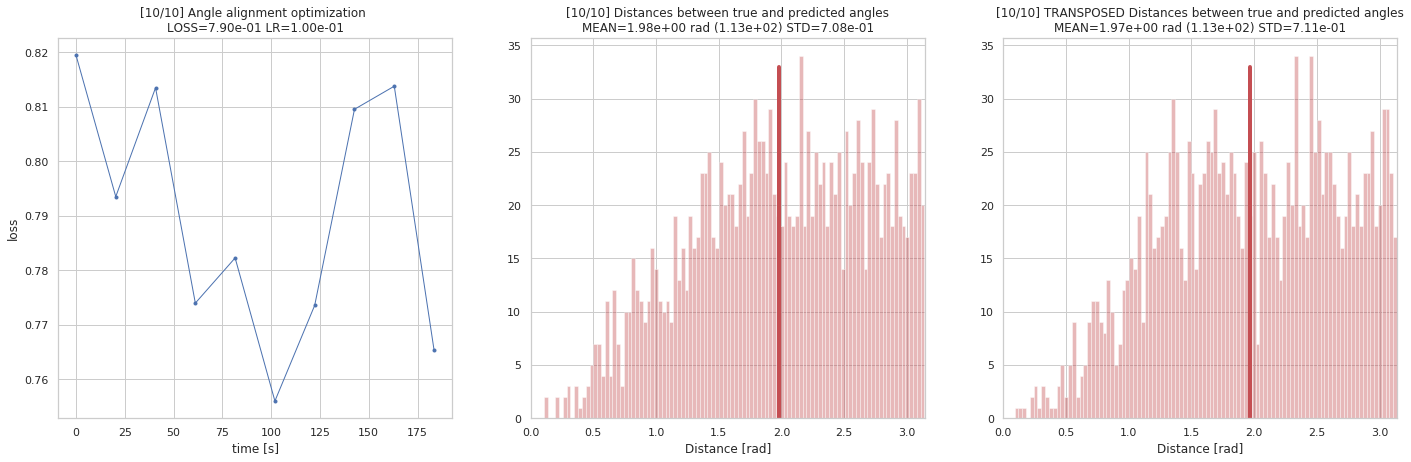

Shape of projections: (1650, 116, 116, 3)step 1/10 (22s): loss = 8.19e-01
step 2/10 (40s): loss = 7.94e-01
step 3/10 (59s): loss = 8.13e-01
step 4/10 (77s): loss = 7.74e-01
step 5/10 (95s): loss = 7.82e-01
step 6/10 (112s): loss = 7.56e-01
step 7/10 (130s): loss = 7.74e-01
step 8/10 (148s): loss = 8.10e-01
step 9/10 (165s): loss = 8.14e-01
step 10/10 (185s): loss = 7.65e-01



In [31]:
q_predicted, losses, q_all = train_angle_recovery(steps=10, 
                                                   batch_size=512, 
                                                   in_data=X[test_idx], 
                                                   distance_fn=d_p, 
                                                   learning_rate=0.1,
                                                   angles_true=y[test_idx],
                                                   optimization=True,
                                                     file_name="data/5j0n/angle_recovery_polynomial",
                                                     dt_type="dP", 
                                                     space="dPspace")

##### Plots

In [ ]:
from cryoem.conversions import quaternion2euler

In [59]:
data      = np.load("data/5j0n/angle_recovery_polynomial.npz")
q_predicted, losses, q_all = data["arr_0"], data["arr_1"], data["arr_2"]
angles_predicted = quaternion2euler(q_predicted).numpy()%(2*np.pi)

In [61]:
from cryoem.plots import plot_iterations_polar_plot, plot_iterations_rotvec

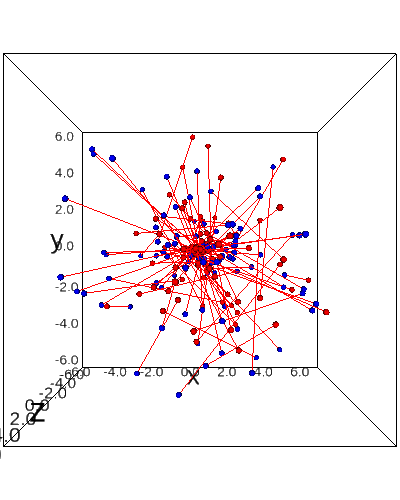

In [65]:
plot_iterations_polar_plot(q_all, angles_true[test_idx], interval=100, selected=range(102));

In [66]:
ipv.screenshot()

Output()

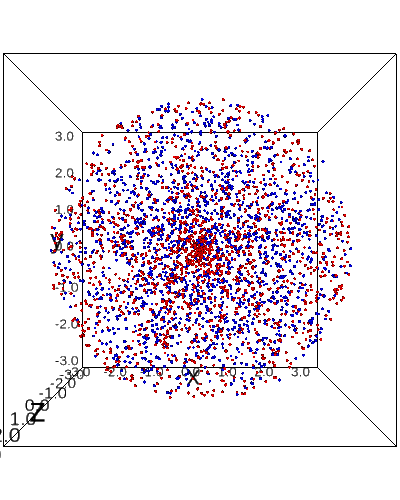

In [67]:
plot_iterations_rotvec(q_all, angles_true[test_idx], interval=100);

In [68]:
ipv.screenshot()

Output()

In [69]:
from cryoem.plots import plot_images

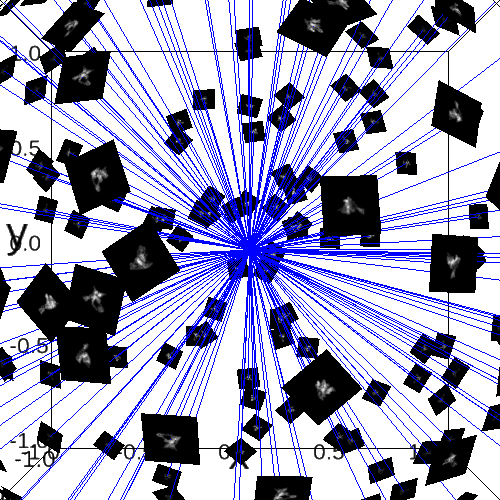

In [70]:
plot_images(angles_predicted, projections, indices=range(200), img_size_scale=0.1)

In [71]:
ipv.screenshot()

Output()

---

# 4. Angle Alignment

The `rotation` is our minimizer and we initialize this 6D vector with random values. That is the reason the optimization sometimes converges to 0 loss and sometimes not.

In [77]:
from cryoem.angle_alignment import training_angle_alignment, update_quaternion

##### Not-flipped

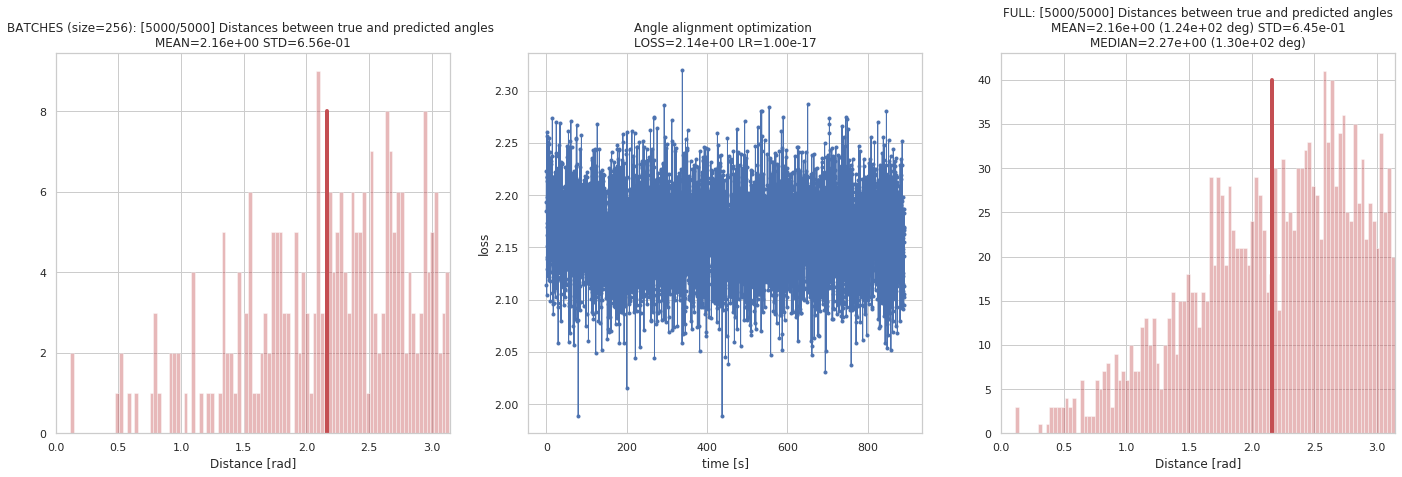

step 500/5000 (96s): loss = 2.17e+00
step 1000/5000 (183s): loss = 2.16e+00
step 1500/5000 (271s): loss = 2.16e+00
step 2000/5000 (358s): loss = 2.16e+00
step 2500/5000 (446s): loss = 2.16e+00
step 3000/5000 (534s): loss = 2.16e+00
step 3500/5000 (622s): loss = 2.16e+00
step 4000/5000 (713s): loss = 2.16e+00
step 4500/5000 (806s): loss = 2.16e+00
step 5000/5000 (892s): loss = 2.16e+00

---


In [80]:
m, rotation, loss, collect_data  = training_angle_alignment(m=[1.0, 1.0, 1.0, 1.0],
                                                 steps=5000, 
                                                 batch_size=256, 
                                                 learning_rate=0.01, 
                                                 angles_true=angles_true[test_idx], 
                                                 angles_predicted=angles_predicted)

In [81]:
m, rotation[0].numpy(), loss[-1]

([1.0, 1.0, 1.0, 1.0],
 array([2.13355493, 3.20832761, 3.42499508, 1.13235032, 6.07880364,
        3.57704655]),
 2.1625712105857064)

###### Flipped

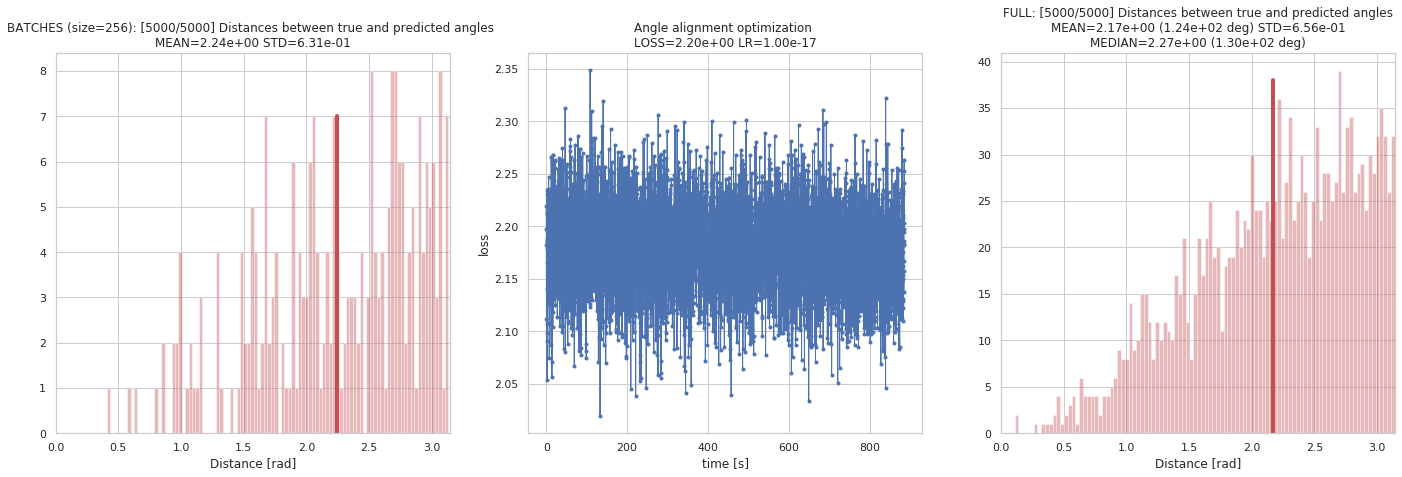

step 500/5000 (89s): loss = 2.18e+00
step 1000/5000 (176s): loss = 2.18e+00
step 1500/5000 (262s): loss = 2.18e+00
step 2000/5000 (349s): loss = 2.18e+00
step 2500/5000 (439s): loss = 2.18e+00
step 3000/5000 (527s): loss = 2.18e+00
step 3500/5000 (617s): loss = 2.18e+00
step 4000/5000 (702s): loss = 2.18e+00
step 4500/5000 (794s): loss = 2.17e+00
step 5000/5000 (886s): loss = 2.17e+00

---


In [75]:
m, rotation, loss, collect_data  = training_angle_alignment(m=[-1.0, 1.0, 1.0, 1.0],
                                                 steps=5000, 
                                                 batch_size=256, 
                                                 learning_rate=0.001, 
                                                 angles_true=angles_true[test_idx], 
                                                 angles_predicted=angles_predicted)

In [76]:
m, rotation[0].numpy(), loss[-1]

([-1.0, 1.0, 1.0, 1.0],
 array([ 1.773942  ,  5.92012581,  2.25840017,  4.82399805,  2.68053836,
        -0.25358452]),
 2.2411800965408157)

##### Plots

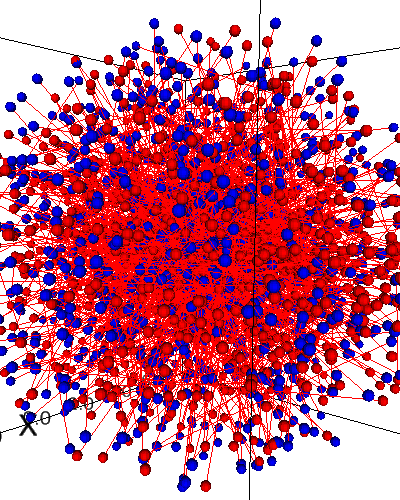

In [83]:
plot_iterations_polar_plot(collect_data, angles_true[test_idx], interval=100);

In [84]:
ipv.screenshot()

Output()

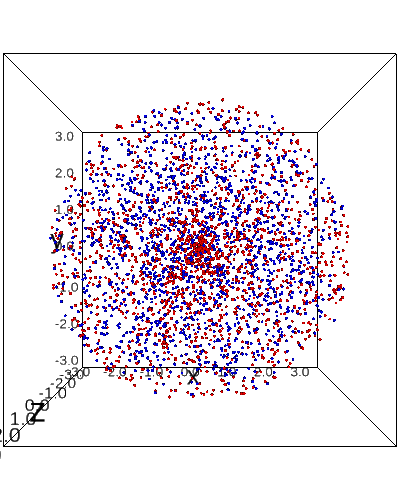

In [85]:
plot_iterations_rotvec(collect_data, angles_true[test_idx]);

In [86]:
ipv.screenshot()

Output()

##### Save alignment result

In [87]:
qpn = euler2quaternion(angles_predicted)

qpa = update_quaternion(m=m, 
                        a_R=rotation, 
                        q_predicted=qpn)

angles_predicted_rotated = quaternion2euler(qpa).numpy()

np.save("data/5j0n/aligned_angles_siamese_polyfit.npy", angles_predicted_rotated)

##### Plot reconstruction image

In [51]:
# Image(filename='../3-reconstruction/data/5j0n_projections_and_angles_predicted_updated.png')